In [58]:
pip install obspy matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


In [59]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read


After Installing all required libraries and Quantum environment, and the filtiration process of the mseed training files, we can now start implementing the QSVM model:


In [60]:
# Reading the MSEED file:
stream = read('event_data.mseed')
print(stream)


1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-01-02T04:35:20.025000Z - 2022-01-02T04:35:40.025000Z | 20.0 Hz, 401 samples


In [62]:
# Get the first trace (since there's only one)
trace = stream[0]

# Extract amplitude data (this is the seismic waveform)
amplitude = trace.data

# Print a preview of the amplitude values
print(amplitude[:10])  # Printing the first 10 amplitude values


[ 114.47104645   42.5131073    50.55516052   18.59721375   43.6392746
  229.68133545  191.72338867 -120.23455811  -77.19250488  117.84955597]


In [63]:
import numpy as np

# Perform Fast Fourier Transform (FFT) on the amplitude data to get frequency components
frequency_data = np.fft.fft(amplitude)

# Get the corresponding frequency values
n = len(amplitude)  # Number of samples
sampling_rate = trace.stats.sampling_rate  # In Hz (20 Hz as per the trace info)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Print the first 10 frequencies and their corresponding Fourier coefficients
print("Frequencies: ", frequencies[:10])
print("Fourier Coefficients (Magnitude): ", np.abs(frequency_data[:10]))


Frequencies:  [0.         0.04987531 0.09975062 0.14962594 0.19950125 0.24937656
 0.29925187 0.34912718 0.39900249 0.44887781]
Fourier Coefficients (Magnitude):  [27712.20776749 15804.19655557  9844.75132904  4971.76044187
  1705.93881719  3394.29903855  2687.96882842  1364.64689878
  2967.55155223   637.07264232]


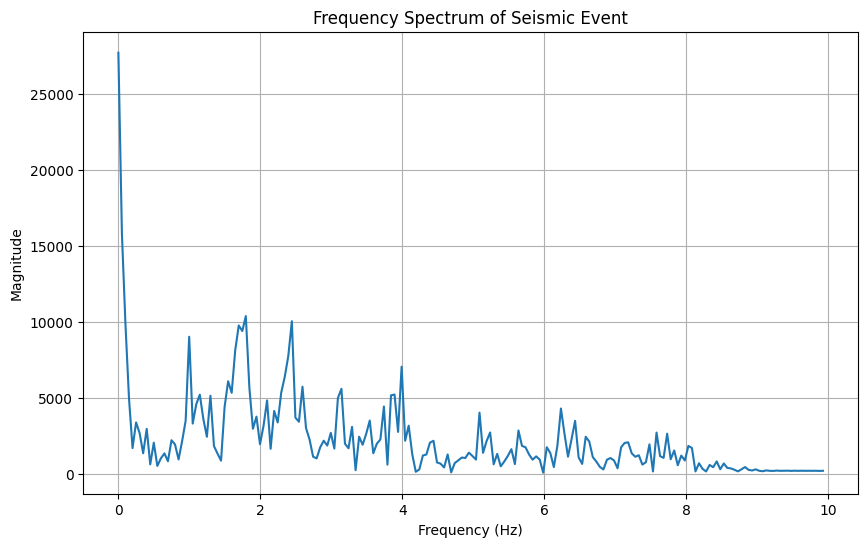

In [64]:
import matplotlib.pyplot as plt

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:n//2], np.abs(frequency_data[:n//2]))  # Only plot the positive frequencies
plt.title('Frequency Spectrum of Seismic Event')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [65]:
from sklearn.preprocessing import StandardScaler

# Stack the frequencies and magnitudes as features
features = np.column_stack((frequencies, np.abs(frequency_data)))

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print(scaled_features[:5])  # View the first few scaled features


[[-1.80518084e-17  9.62303166e+00]
 [ 8.63868426e-03  5.13171758e+00]
 [ 1.72773685e-02  2.88400889e+00]
 [ 2.59160528e-02  1.04607540e+00]
 [ 3.45547370e-02 -1.85686176e-01]]


In [105]:
# Step 1: Check the shape of scaled_features
print("Scaled Features Shape:", scaled_features.shape)

# Step 2: Create correct labels
num_samples = scaled_features.shape[0]  # Number of samples in scaled features
labels = np.array([1] * (num_samples // 2) + [0] * (num_samples - (num_samples // 2)) )  # Adjust this accordingly

# Check labels shape
print("Labels Shape:", labels.shape)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)



Scaled Features Shape: (801, 2)
Labels Shape: (801,)
Training Set Shape: (640, 2)
Test Set Shape: (161, 2)


In [69]:
pip install qiskit qiskit-machine-learning


Note: you may need to restart the kernel to use updated packages.


In [70]:
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)


X_train Shape: (320, 2)
y_train Shape: (320,)


In [91]:
from qiskit_aer import Aer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler

# Create a simple quantum circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

In [97]:
from qiskit_aer import Aer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler

# Create a simple quantum circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Set up the sampler
sampler = Sampler()

# Create a fidelity quantum kernel
fidelity_kernel = FidelityQuantumKernel()

C:\Users\hp\AppData\Local\Temp\ipykernel_6596\2289565111.py:13: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [98]:
# Set up the QSVC algorithm
qsvc = QSVC(quantum_kernel=fidelity_kernel)

In [99]:
# Train the QSVC model
qsvc.fit(X_train, y_train)

# Evaluate the model
score = qsvc.score(X_test, y_test)
print("QSVC Test Accuracy:", score)

QSVC Test Accuracy: 0.5802469135802469


1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-02-03T08:08:07.009000Z - 2022-02-03T08:08:47.009000Z | 20.0 Hz, 801 samples
[ 43.02890396 -50.98473358 -12.99837494 -35.0120163  -36.02565002
   2.96070862   5.94707108  14.93343163 -35.08020782 -68.09384918]
Frequencies:  [0.         0.02496879 0.04993758 0.07490637 0.09987516 0.12484395
 0.14981273 0.17478152 0.19975031 0.2247191 ]
Fourier Coefficients (Magnitude):  [7220.80788994 3586.09393342 2774.85814782 2285.23712079 3163.51441621
 2531.29730821 6131.82546143 6136.52539937 3717.16081034 3697.10104072]


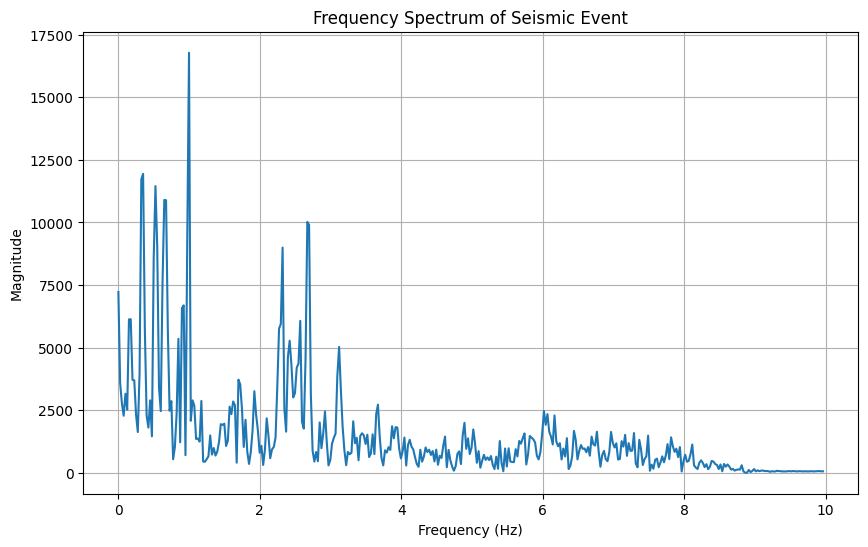

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Reading the MSEED file:
stream = read('new_event_data.mseed')
print(stream)


# Get the first trace (since there's only one)
trace = stream[0]

# Extract amplitude data (this is the seismic waveform)
amplitude = trace.data

# Print a preview of the amplitude values
print(amplitude[:10])  # Printing the first 10 amplitude values


import numpy as np

# Perform Fast Fourier Transform (FFT) on the amplitude data to get frequency components
frequency_data = np.fft.fft(amplitude)

# Get the corresponding frequency values
n = len(amplitude)  # Number of samples
sampling_rate = trace.stats.sampling_rate  # In Hz (20 Hz as per the trace info)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Print the first 10 frequencies and their corresponding Fourier coefficients
print("Frequencies: ", frequencies[:10])
print("Fourier Coefficients (Magnitude): ", np.abs(frequency_data[:10]))




import matplotlib.pyplot as plt

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:n//2], np.abs(frequency_data[:n//2]))  # Only plot the positive frequencies
plt.title('Frequency Spectrum of Seismic Event')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [103]:
from sklearn.preprocessing import StandardScaler

# Stack the frequencies and magnitudes as features
features = np.column_stack((frequencies, np.abs(frequency_data)))

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print(scaled_features[:5])  # View the first few scaled features


# Step 1: Check the shape of scaled_features
print("Scaled Features Shape:", scaled_features.shape)

# Step 2: Create correct labels
num_samples = scaled_features.shape[0]  # Number of samples in scaled features
labels = np.array([1] * (num_samples // 2) + [0] * (num_samples - (num_samples // 2)) )  # Adjust this accordingly

# Check labels shape
print("Labels Shape:", labels.shape)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

[[-2.72224869e-17  2.70917633e+00]
 [ 4.32472449e-03  9.86251127e-01]
 [ 8.64944898e-03  6.01709565e-01]
 [ 1.29741735e-02  3.69619663e-01]
 [ 1.72988980e-02  7.85940206e-01]]
Scaled Features Shape: (801, 2)
Labels Shape: (801,)
Training Set Shape: (640, 2)
Test Set Shape: (161, 2)


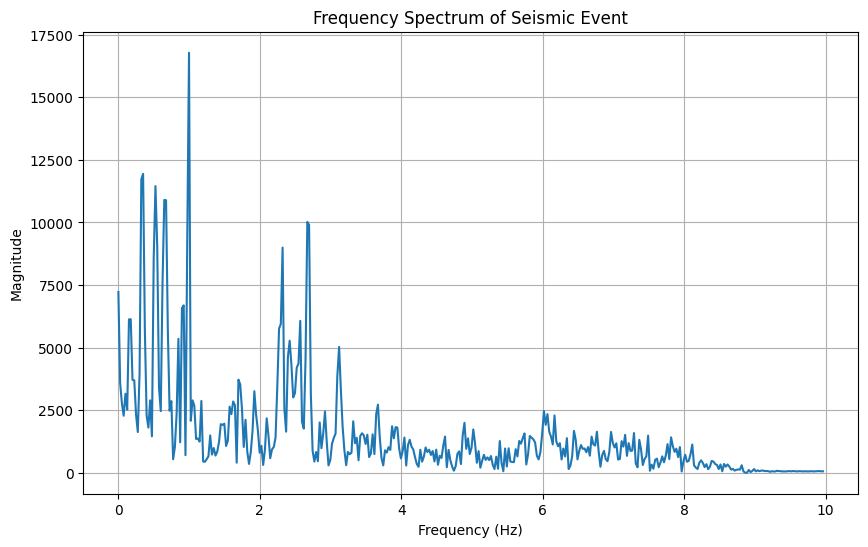

Scaled Features Shape: (801, 2)
Training Set Shape: (640, 2)
Test Set Shape: (161, 2)


C:\Users\hp\AppData\Local\Temp\ipykernel_6596\1065123328.py:59: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


QSVC Test Accuracy: 0.6770186335403726


In [104]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from qiskit_aer import Aer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler

# Load seismic data
stream = read('new_event_data.mseed')
trace = stream[0]
amplitude = trace.data

# Perform FFT to get frequency components
frequency_data = np.fft.fft(amplitude)
n = len(amplitude)
sampling_rate = trace.stats.sampling_rate
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:n//2], np.abs(frequency_data[:n//2]))
plt.title('Frequency Spectrum of Seismic Event')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# Stack the frequencies and magnitudes as features
features = np.column_stack((frequencies, np.abs(frequency_data)))

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the shape of scaled_features
print("Scaled Features Shape:", scaled_features.shape)

# Create labels (adjust as necessary)
num_samples = scaled_features.shape[0]
labels = np.array([1] * (num_samples // 2) + [0] * (num_samples - (num_samples // 2)))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

# Check shapes
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

# Create a simple quantum circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Set up the sampler
sampler = Sampler()

# Create a fidelity quantum kernel
fidelity_kernel = FidelityQuantumKernel()

# Set up the QSVC algorithm
qsvc = QSVC(quantum_kernel=fidelity_kernel)

# Train the QSVC model
qsvc.fit(X_train, y_train)

# Evaluate the model
score = qsvc.score(X_test, y_test)
print("QSVC Test Accuracy:", score)
